In [98]:

import numpy as np
import pandas as pd
import _pickle as pickle
#from collections import defaultdict
#import re
#import ast

# from bs4 import BeautifulSoup

import sys
import os
import json
import operator

#from keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical

#from keras import backend as K
#from keras.engine.topology import Layer, InputSpec
#from keras import initializers

#from keras.optimizers import SGD

#from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, GlobalAveragePooling1D, LSTM, GRU, Bidirectional, dot, multiply, Lambda, TimeDistributed, Masking

#from keras.models import Model, Sequential
#from keras.regularizers import l2,l1,l1_l2
#from keras.callbacks import Callback,EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

#from keras.callbacks import Callback


#from keras.layers.normalization import BatchNormalization
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer 
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import text

In [3]:
from sklearn.metrics import average_precision_score

In [4]:
import pickle

In [5]:
import optunity.metrics

In [6]:
from scipy import sparse

In [55]:
from sklearn.calibration import calibration_curve

In [7]:
def load_data(data_name):
    f = open(data_name,'rb')
    data = pickle.load(f)
    return data

In [8]:
train_labels = load_data('/home/jujun/fraudprediction_10k/data/y_train_20200214')

In [9]:
len(train_labels)

45030

In [10]:
test_labels = load_data('/home/jujun/fraudprediction_10k/data/y_test_20200214')

In [11]:
len(test_labels)

11258

In [12]:
train_indecis = load_data('/home/jujun/fraudprediction_10k/data/indices_train_20200214')

In [13]:
test_indecis = load_data('/home/jujun/fraudprediction_10k/data/indices_test_20200214')

In [14]:
data = load_data('/home/jujun/fraudprediction_10k/data/data_20200212_2012')

In [15]:
text_para = []
for d in data:
    text_para.append(d[0])

In [16]:
def generate_doc(x):
    return ' '.join(x)

In [17]:
text_doc = []
for d in text_para:
    text_doc.append(generate_doc(d))

In [31]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["dd"])

In [32]:
tfidf_vect = TfidfVectorizer(stop_words = my_stop_words, min_df=5)
tm= tfidf_vect.fit_transform(text_doc)

In [19]:
#type(tm)

scipy.sparse.csr.csr_matrix

In [20]:
#tm

<56288x69185 sparse matrix of type '<class 'numpy.float64'>'
	with 48325957 stored elements in Compressed Sparse Row format>

In [21]:
#sparse.save_npz('/home/jujun/fraudprediction_10k/data/tm_20200212', tm)

In [23]:
text_doc_test = [text_doc[idx] for idx in test_indecis]

In [24]:
len(text_doc_test)

11258

In [25]:
# tm = sparse.load_npz("/home/jujun/fraudprediction_10k/data/tm_20200212.npz")

In [26]:
X_train = tm[train_indecis]
X_test = tm[test_indecis]

In [27]:
X_train.shape

(45030, 69185)

In [28]:
X_test.shape

(11258, 69185)

In [29]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

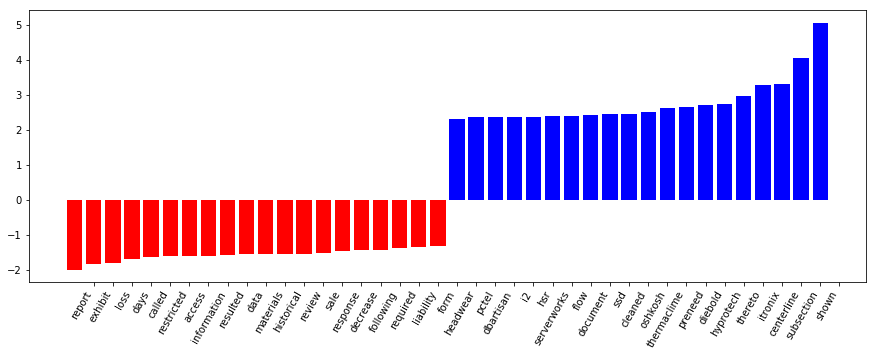

In [56]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values
class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 10
# class_weights_dict = {}
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

feacture_names = tfidf_vect.get_feature_names()
plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc_score = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc_score,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

#fop, mpv = calibration_curve(test_labels, decision_values, n_bins=10, normalize=True)


# c = make_pipeline(tfidf_vect, clf)

# explainer = LimeTextExplainer(class_names = ['0','1'])
# doc_test = [doc_cl[i] for i in test_index]


In [60]:
clb = CalibratedClassifierCV(svm, method='sigmoid')
clb.fit(X_train, train_labels)
clb_prob = clb.predict_proba(X_test)

In [34]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.924522,0.491416,0.996146,0.574257,0.996146,0.574257,0.996146,0.574257,11157,101


In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [36]:
X_test.shape

(11258, 69185)

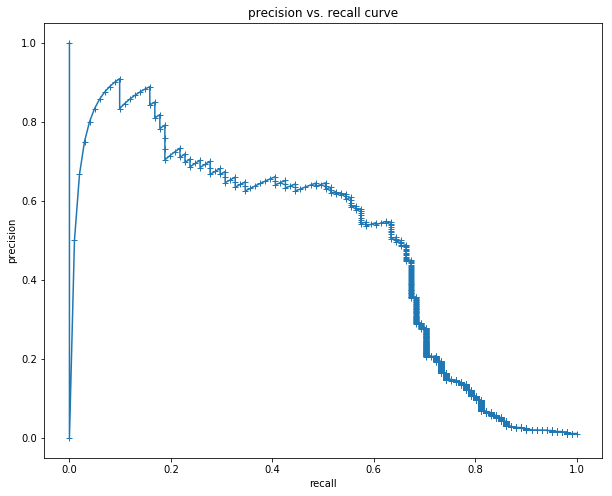

In [45]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(10,8))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()

In [38]:
rc

array([1.        , 0.99009901, 0.99009901, ..., 0.00990099, 0.        ,
       0.        ])

In [39]:
prc

array([0.01141501, 0.01130327, 0.01130454, ..., 0.5       , 0.        ,
       1.        ])

In [42]:
ap_1 = auc(rc, prc)

In [43]:
ap_1

0.48492524721120756

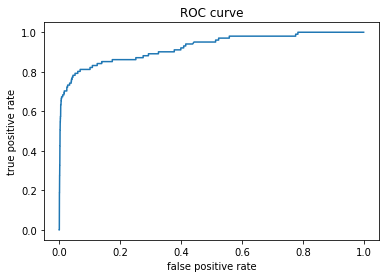

In [44]:
fpr, tpr, _ = roc_curve(test_labels, decision_values)

plt.plot(fpr, tpr)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.show()

In [46]:
decision_values

array([-1.15688678, -1.89250901, -1.06395982, ..., -1.15475869,
       -1.37291048, -1.30871688])

In [61]:
test_tb = pd.read_csv('/home/jujun/fraudprediction_10k/data/test_insight_20200214.csv')

In [62]:
test_tb.head()

,file,cik,label
0,edgar/data/815910/0000815910-04-000041.txt,815910,0
1,edgar/data/1294538/0000950124-05-001833.txt,1294538,0
2,edgar/data/49401/0000049401-05-000016.txt,49401,0
3,edgar/data/1326973/0000950134-07-023627.txt,1326973,0
4,edgar/data/1043000/0000950134-06-006443.txt,1043000,0


In [64]:
clb_prob

array([[9.92816167e-01, 7.18383252e-03],
       [9.99134783e-01, 8.65217481e-04],
       [9.93494099e-01, 6.50590108e-03],
       ...,
       [9.96561367e-01, 3.43863255e-03],
       [9.96557165e-01, 3.44283452e-03],
       [9.96245804e-01, 3.75419588e-03]])

In [66]:
test_tb['pred_prob'] = clb_prob[:,1]

In [67]:
test_tb.head()

,file,cik,label,pred_prob
0,edgar/data/815910/0000815910-04-000041.txt,815910,0,0.007184
1,edgar/data/1294538/0000950124-05-001833.txt,1294538,0,0.000865
2,edgar/data/49401/0000049401-05-000016.txt,49401,0,0.006506
3,edgar/data/1326973/0000950134-07-023627.txt,1326973,0,0.002342
4,edgar/data/1043000/0000950134-06-006443.txt,1043000,0,0.013362


In [68]:
test_tb_fraud = test_tb[test_tb.label == 1]

In [69]:
cik_fraud = list(set(test_tb_fraud.cik))

In [71]:
test_tb_fraud = test_tb[test_tb.cik.isin(cik_fraud)]

In [72]:
test_tb_fraud.head(20)

,file,cik,label,pred_prob
20,edgar/data/860518/0000949303-00-000171.txt,860518,0,0.035448
58,edgar/data/737561/0000737561-05-000024.txt,737561,1,0.739874
143,edgar/data/933974/0000950135-05-006941.txt,933974,1,0.103282
154,edgar/data/1051118/0001193125-05-038641.txt,1051118,0,0.018622
175,edgar/data/1012482/0001193125-06-253438.txt,1012482,0,0.014160
222,edgar/data/1292055/0001193125-05-061017.txt,1292055,1,0.270050
296,edgar/data/1095600/0001193125-03-025762.txt,1095600,1,0.197626
298,edgar/data/73887/0000899243-98-001228.txt,73887,0,0.262550
419,edgar/data/109156/0000950134-05-018666.txt,109156,1,0.524986
593,edgar/data/826083/0000950134-07-022267.txt,826083,1,0.015368


In [78]:
len(cik_fraud)

78

In [77]:
test_tb_fraud.shape

(211, 4)

In [96]:
np.average(test_tb_fraud[test_tb_fraud.cik == 51644].pred_prob)

0.008273742610845512

In [97]:
np.average(test_tb_fraud[(test_tb_fraud.cik == 51644)&(test_tb_fraud.label == 1)].pred_prob)

0.012118756827490425

In [93]:
pvtb_fraud_svm = pd.pivot_table(test_tb_fraud, values='pred_prob', index=['cik'], columns =['label'],
                     aggfunc=[np.average,len], margins=True)

In [99]:
pvtb_fraud_svm.head()

average                      len          
label         0         1       All    0    1  All
cik                                               
3116   0.003869  0.003486  0.003792  4.0  1.0  5.0
3662        NaN  0.004072  0.004072  NaN  1.0  1.0
14272  0.005132  0.004862  0.004997  1.0  1.0  2.0
23217       NaN  0.015070  0.015070  NaN  1.0  1.0
26172  0.047770  0.394565  0.221167  1.0  1.0  2.0

In [117]:
pvtb_fraud_svm_ave_1 = pvtb_fraud_svm['average'][1].rename('prob_ave')

pvtb_fraud_svm_len_1 = pvtb_fraud_svm['len'][1].rename('count_lb_1')

tb_lb_1 = pd.concat([pvtb_fraud_svm_ave_1, pvtb_fraud_svm_len_1],axis=1)

tb_lb_1 = tb_lb_1.drop('All',axis =0)

tb_lb_1 = tb_lb_1.sort_values(by=['count_lb_1'])

In [128]:
tb_lb_1.head()

,prob_ave,count_lb_1
cik,,
3116,0.003486,1.0
929994,0.636868,1.0
932112,0.003303,1.0
933974,0.103282,1.0
935802,0.425730,1.0


In [129]:
tb_lb_1.tail()

,prob_ave,count_lb_1
cik,,
1107112,0.482855,3.0
278352,0.187323,3.0
859475,0.557794,3.0
73887,0.205653,3.0
1054374,0.171161,5.0


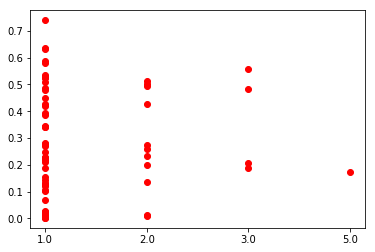

In [140]:
x_axis = [str(i) for i in tb_lb_1.count_lb_1]
plt.plot(x_axis, tb_lb_1.prob_ave,'ro')
plt.show()

In [49]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 75
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [50]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.92473,0.389777,0.994114,0.498084,0.996756,0.40625,0.991485,0.643564,11157,101


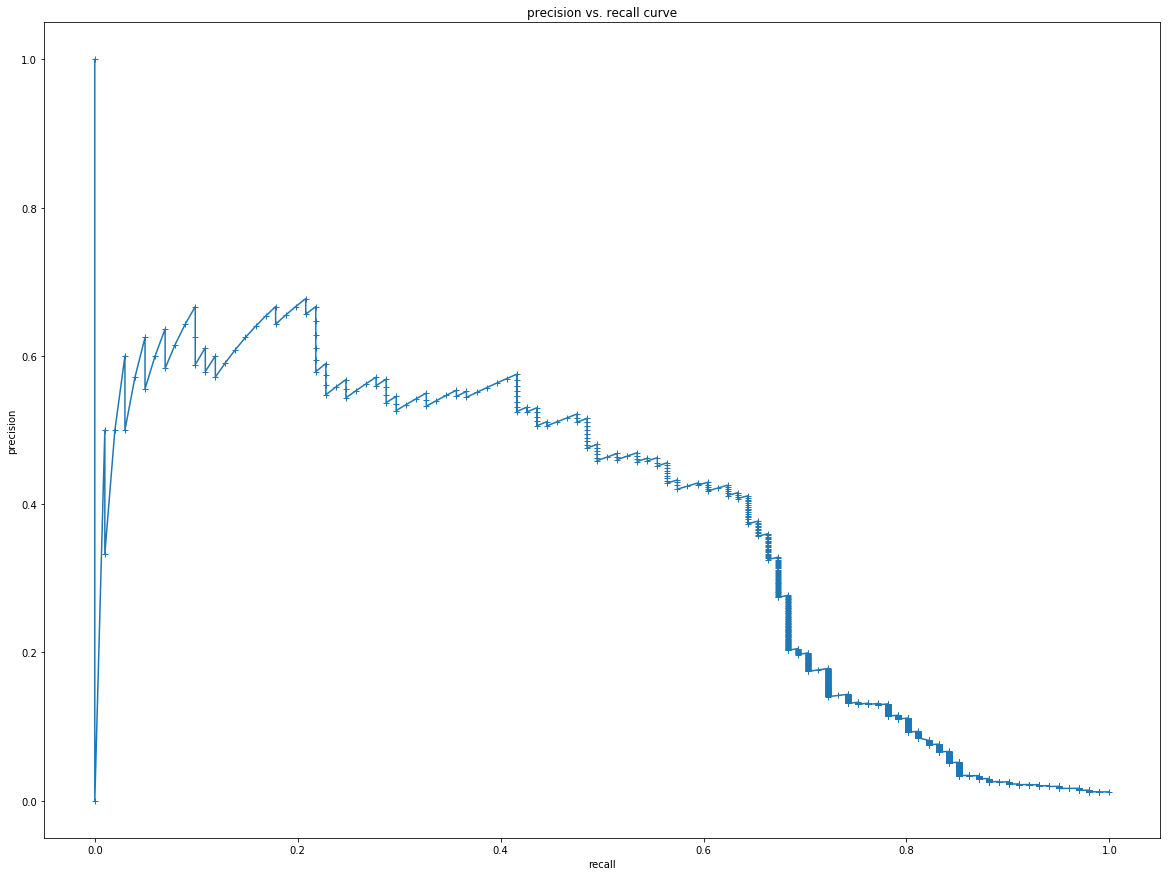

In [51]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(20,15))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()

In [52]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 50
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [53]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.925169,0.427077,0.99443,0.511811,0.996758,0.424837,0.992113,0.643564,11157,101


In [54]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 25
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [55]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.925004,0.467583,0.995243,0.547009,0.996674,0.481203,0.993816,0.633663,11157,101


In [56]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 10
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [57]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.924522,0.491416,0.996146,0.574257,0.996146,0.574257,0.996146,0.574257,11157,101


In [58]:
train_labels = pd.Series(train_labels)
f = 0

aucs = ()
aucs_list = []

precisions = ()

recalls = ()

result = pd.DataFrame()

#exp_weight= []

#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#embedding_matrix = np.load('embedding_matrix_0721.npy')
#for train_index, test_index in kfold.split(X_train,labels_train):
#     print(' ')

# f = f+1
# print('molde_'+str(f))
# print('train: ',train_index[0], ' / ', train_index[-1])
# print('test: ',test_index[0],' / ', test_index[-1])
#ModelName = './folder(6)/basicM_bestM_l12_'+str(f)
# x_traink, x_val = tm[train_index], tm[test_index]
# y_traink, y_val = labels_train[train_index].values, labels_train[test_index].values

class_weights_dict = {}
class_weights_dict[0] = 1
class_weights_dict[1] = 5
# class_weights = class_weight.compute_class_weight('balanced',
#                                              np.unique(train_labels),
#                                              train_labels)
# class_weights_dict[0] = class_weights[0]
# class_weights_dict[1] = class_weights[1]
# print(class_weights_dict)

svm = LinearSVC(class_weight = class_weights_dict)
svm.fit(X_train, train_labels)

#feacture_names = tfidf_vect.get_feature_names()

#plot_coefficients(svm, feacture_names)

decision_values = svm.decision_function(X_test)
auc = roc_auc_score(test_labels, decision_values)

pred = svm.predict(X_test)
prfs = precision_recall_fscore_support(test_labels, pred)


ap = average_precision_score(test_labels, decision_values)
#     if f == 1:
#         pred_1= np.array([test_index,pred,decision_values])
#     else: pred_2= np.array([test_index,pred,decision_values])

dict_temp = {
    'average_precision':ap,
    'auc':auc,'precision_label_0':prfs[0][0],'precision_label_1':prfs[0][1],
    'recall_label_0':prfs[1][0],'recall_label_1':prfs[1][1],
    'fscore_label_0':prfs[2][0],'fscore_label_1':prfs[2][1],
    'support_label_0':prfs[3][0],'support_label_1':prfs[3][1],
}
temp_table = pd.DataFrame(dict_temp,index=[f])
result = pd.concat([temp_table,result])

In [59]:
result

,auc,average_precision,fscore_label_0,fscore_label_1,precision_label_0,precision_label_1,recall_label_0,recall_label_1,support_label_0,support_label_1
0,0.924366,0.490773,0.996285,0.531073,0.995171,0.618421,0.997401,0.465347,11157,101


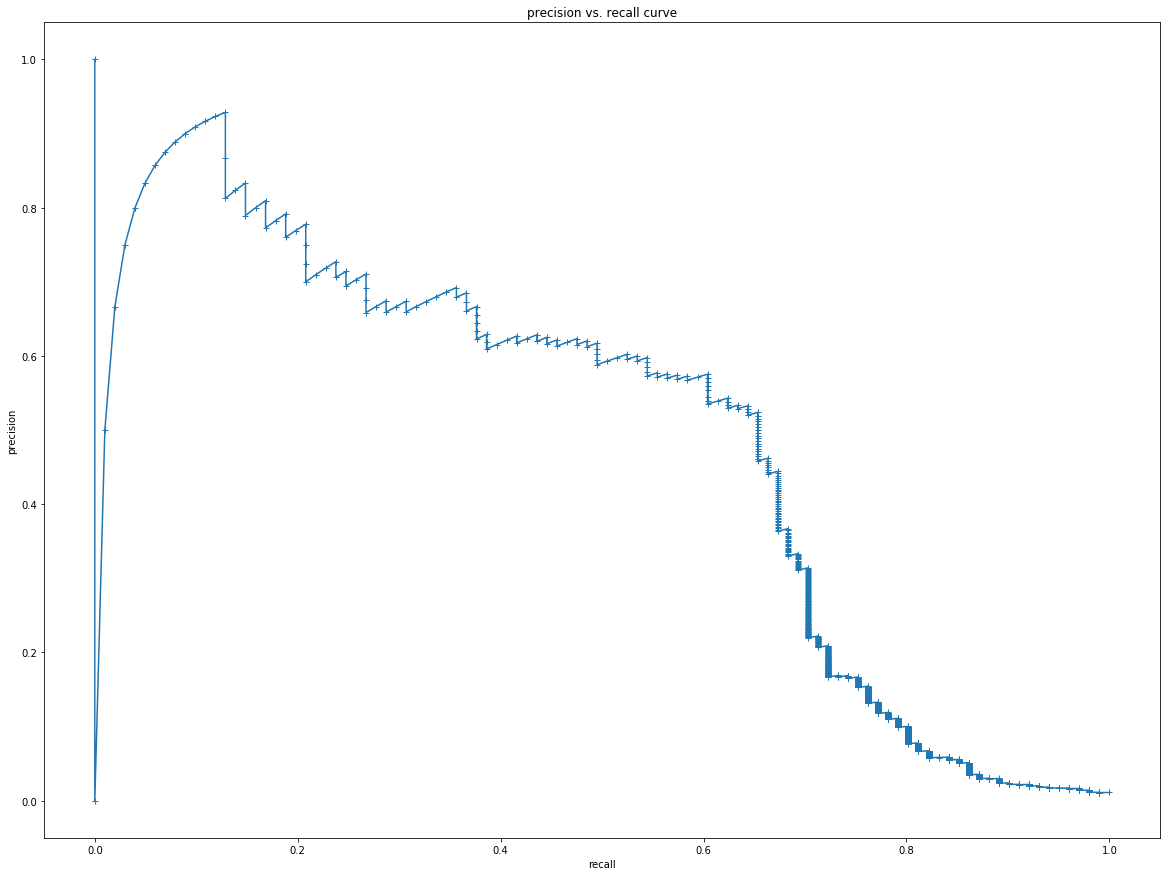

In [60]:
prc,rc,_ = precision_recall_curve(test_labels, decision_values)

plt.figure(figsize=(20,15))
plt.plot(rc,prc,marker = '+')

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs. recall curve")
plt.show()